In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing,linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Import the data:

In [10]:
Data = pd.read_csv(".\\consumer_complaints.csv",encoding='latin-1',low_memory=False)

## Data understanding
#### Selecting required columns and rows

In [3]:
Data.dtypes
Data = Data[['product', 'consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]

# Factorizing the category column
Data['category_id'] = Data['product'].factorize()[0]

# Check the distriution of complaints by category
Data.groupby('product').consumer_complaint_narrative.count()


product
Bank account or service     5711
Consumer Loan               3678
Credit card                 7929
Credit reporting           12526
Debt collection            17552
Money transfers              666
Mortgage                   14919
Other financial service      110
Payday loan                  726
Prepaid card                 861
Student loan                2128
Name: consumer_complaint_narrative, dtype: int64

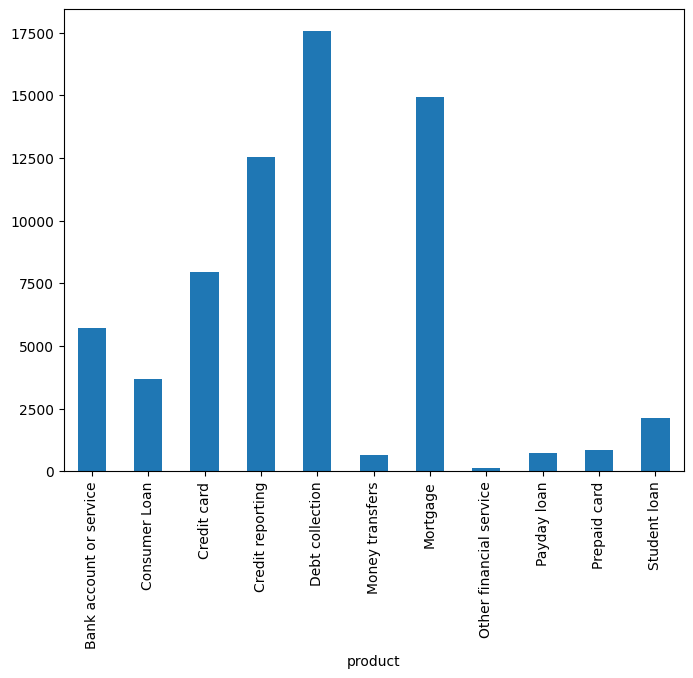

In [4]:
fig = plt.figure(figsize=(8,6))
Data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

##  Splitting the data

In [5]:
# Split the data into train and validation
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(Data['consumer_complaint_narrative'], Data['product'])

##  Feature engineering using TF-IDF

In [6]:
# Create TF-IDF vectors. Here we consider maximum features to be 5000.
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer(analyzer='word', 
token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(Data['consumer_complaint_narrative'])
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

## Model building and evaluation

In [7]:
logreg_model = linear_model.LogisticRegression(max_iter=500).fit(xtrain_tfidf, train_y)
nb_model = naive_bayes.MultinomialNB().fit(xtrain_tfidf, train_y)   
svc_model = LinearSVC(max_iter=500, dual=False).fit(xtrain_tfidf, train_y)  
# Model summary
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=100, multi_class='ovr', 
n_jobs=1,
penalty='l2', random_state=None, solver='liblinear', 
tol=0.0001,
verbose=0, warm_start=False)

# Evaluate Logistic Regression
logreg_accuracy = metrics.accuracy_score(logreg_model.predict(xvalid_tfidf), valid_y)
print("Logistic Regression Accuracy: ", logreg_accuracy)
print(metrics.classification_report(valid_y, logreg_model.predict(xvalid_tfidf), target_names=Data['product'].unique(), zero_division=0))

# Evaluate Naive Bayes
nb_accuracy = metrics.accuracy_score(nb_model.predict(xvalid_tfidf), valid_y)
print("Naive Bayes Accuracy: ", nb_accuracy)
print(metrics.classification_report(valid_y, nb_model.predict(xvalid_tfidf), target_names=Data['product'].unique(), zero_division=0))

# Evaluate Linear SVC
svc_accuracy = metrics.accuracy_score(svc_model.predict(xvalid_tfidf), valid_y)
print("Linear SVC Accuracy: ", svc_accuracy)
print(metrics.classification_report(valid_y, svc_model.predict(xvalid_tfidf), target_names=Data['product'].unique(), zero_division=0))


Logistic Regression Accuracy:  0.8447491318404982
                         precision    recall  f1-score   support

        Debt collection       0.80      0.79      0.79      1438
          Consumer Loan       0.75      0.60      0.67       895
               Mortgage       0.80      0.82      0.81      1936
            Credit card       0.84      0.86      0.85      3090
       Credit reporting       0.83      0.89      0.86      4477
           Student loan       0.74      0.47      0.58       167
Bank account or service       0.92      0.95      0.94      3749
            Payday loan       0.00      0.00      0.00        26
        Money transfers       0.73      0.26      0.38       199
Other financial service       0.78      0.63      0.70       207
           Prepaid card       0.87      0.75      0.80       518

               accuracy                           0.84     16702
              macro avg       0.73      0.64      0.67     16702
           weighted avg       0.84    

In [8]:
# Create Voting Classifier
voting_model = VotingClassifier(estimators=[
        ('logreg', logreg_model), 
        ('naive_bayes', nb_model),
        ('linear_svc', svc_model)
    ], voting='hard')

voting_model.fit(xtrain_tfidf, train_y)

model = voting_model
# Evaluate Voting Classifier
voting_accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf), valid_y)
print("Voting Classifier Accuracy: ", voting_accuracy)
print(metrics.classification_report(valid_y, model.predict(xvalid_tfidf), target_names=Data['product'].unique(), zero_division=0))


Voting Classifier Accuracy:  0.8463657047060232
                         precision    recall  f1-score   support

        Debt collection       0.79      0.78      0.79      1438
          Consumer Loan       0.75      0.60      0.67       895
               Mortgage       0.80      0.82      0.81      1936
            Credit card       0.85      0.87      0.86      3090
       Credit reporting       0.83      0.89      0.86      4477
           Student loan       0.75      0.46      0.57       167
Bank account or service       0.92      0.96      0.94      3749
            Payday loan       0.00      0.00      0.00        26
        Money transfers       0.77      0.23      0.36       199
Other financial service       0.79      0.60      0.68       207
           Prepaid card       0.88      0.76      0.82       518

               accuracy                           0.85     16702
              macro avg       0.74      0.63      0.67     16702
           weighted avg       0.84      

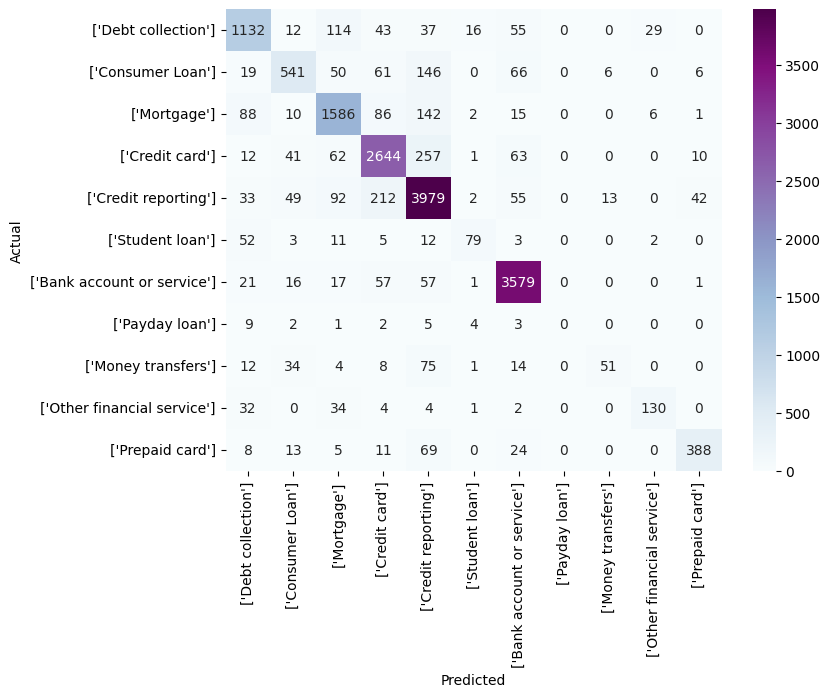

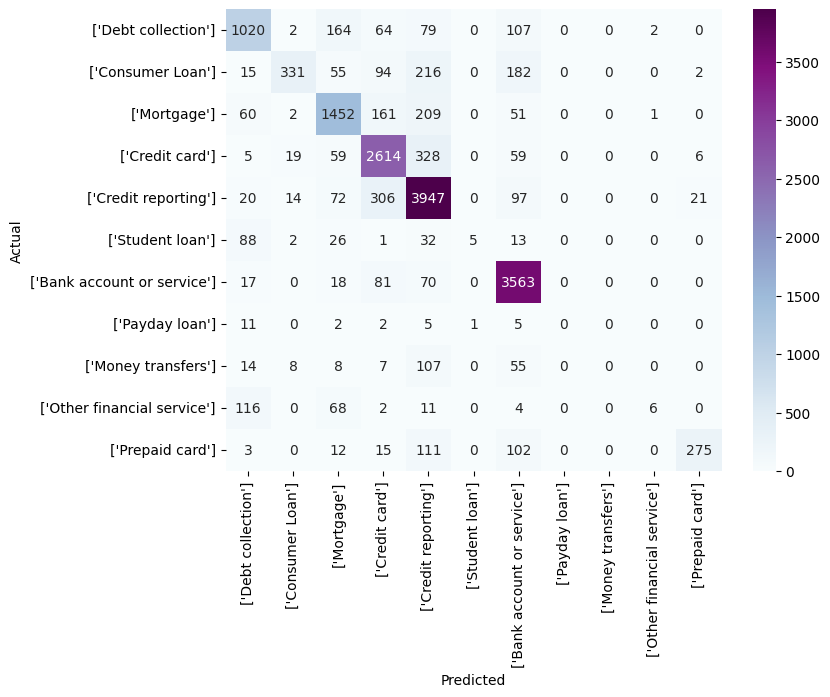

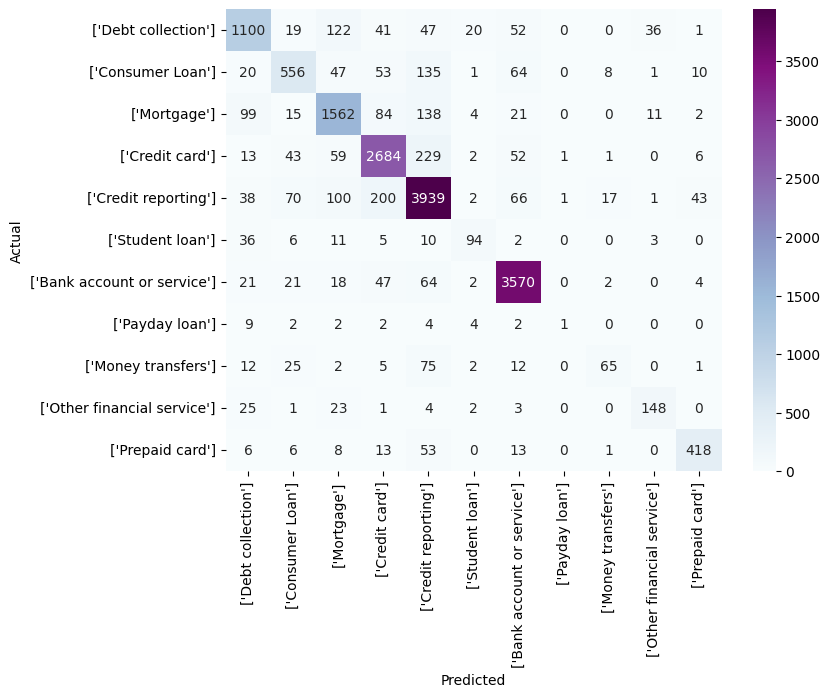

In [9]:
#confusion matrix
conf_mat = confusion_matrix(valid_y, logreg_model.predict(xvalid_tfidf))
# Vizualizing confusion matrix
category_id_df = Data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",xticklabels=category_id_df[['product']].values, yticklabels=category_id_df[['product']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#confusion matrix
conf_mat = confusion_matrix(valid_y, nb_model.predict(xvalid_tfidf))
# Vizualizing confusion matrix
category_id_df = Data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",xticklabels=category_id_df[['product']].values, yticklabels=category_id_df[['product']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#confusion matrix
conf_mat = confusion_matrix(valid_y, svc_model.predict(xvalid_tfidf))
# Vizualizing confusion matrix
category_id_df = Data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",xticklabels=category_id_df[['product']].values, yticklabels=category_id_df[['product']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()